In [2]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f'Wierzcholki: {data.num_nodes}')
print(f'Liczba krawędzi: {data.num_edges}')
print(f'Liczba cech na węzeł: {data.num_node_features}')
print(f'Liczba klas do przewidzenia: {dataset.num_classes}')


Wierzcholki: 2708
Liczba krawędzi: 10556
Liczba cech na węzeł: 1433
Liczba klas do przewidzenia: 7


In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return x


model = GCN(num_features=dataset.num_node_features,
            hidden_channels=16,
            num_classes=dataset.num_classes)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    correct = pred[mask] == data.y[mask]

    acc = int(correct.sum()) / int(mask.sum())
    return acc

epochs = 1000
best_val_acc = 0.0

print("\n--- Rozpoczęcie Treningu ---")
for epoch in range(1, epochs + 1):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    if val_acc > best_val_acc:
        best_val_acc = val_acc

        torch.save(model.state_dict(), 'fgcn_model.pt')

    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print("\n--- Trening Zakończony ---")
final_test_acc = test(data.test_mask)
print(f'Finalna Dokładność Testowa: {final_test_acc:.4f}')


--- Rozpoczęcie Treningu ---
Epoch: 020, Loss: 0.0016, Val Acc: 0.7640, Test Acc: 0.7730
Epoch: 040, Loss: 0.0086, Val Acc: 0.7600, Test Acc: 0.7780
Epoch: 060, Loss: 0.0032, Val Acc: 0.7580, Test Acc: 0.7830
Epoch: 080, Loss: 0.0004, Val Acc: 0.7600, Test Acc: 0.7790
Epoch: 100, Loss: 0.0026, Val Acc: 0.7580, Test Acc: 0.7870
Epoch: 120, Loss: 0.0025, Val Acc: 0.7600, Test Acc: 0.7880
Epoch: 140, Loss: 0.0013, Val Acc: 0.7580, Test Acc: 0.7780
Epoch: 160, Loss: 0.0008, Val Acc: 0.7560, Test Acc: 0.7760
Epoch: 180, Loss: 0.0004, Val Acc: 0.7640, Test Acc: 0.7780
Epoch: 200, Loss: 0.0002, Val Acc: 0.7440, Test Acc: 0.7860
Epoch: 220, Loss: 0.0010, Val Acc: 0.7440, Test Acc: 0.7800
Epoch: 240, Loss: 0.0014, Val Acc: 0.7460, Test Acc: 0.7690
Epoch: 260, Loss: 0.0026, Val Acc: 0.7440, Test Acc: 0.7690
Epoch: 280, Loss: 0.0003, Val Acc: 0.7520, Test Acc: 0.7750
Epoch: 300, Loss: 0.0004, Val Acc: 0.7360, Test Acc: 0.7660
Epoch: 320, Loss: 0.0006, Val Acc: 0.7360, Test Acc: 0.7710
Epoch: 340

In [11]:
@torch.no_grad()
def get_node_embeddings(data):
    # Możemy zwrócić surowe logity (wyjście przed softmax)
    model.eval()
    out = model(data.x, data.edge_index) 
    return out.cpu().numpy(), data.y.cpu().numpy()
    
# Zbieranie reprezentacji (embeddingów)
embeddings, true_labels = get_node_embeddings(data)

In [12]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

original_features_2d = tsne.fit_transform(data.x.cpu().numpy())

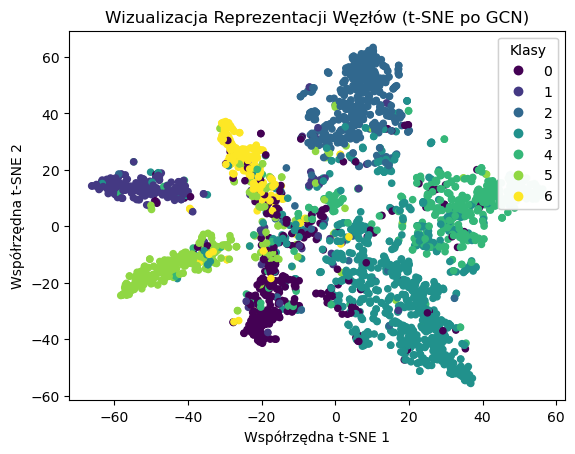

In [13]:

scatter = plt.scatter(
    embeddings_2d[:, 0], # Współrzędna X
    embeddings_2d[:, 1], # Współrzędna Y
    c=true_labels,       # Kolorowanie według prawdziwej etykiety
    cmap='viridis',
    s=20
)

legend1 = plt.legend(*scatter.legend_elements(), 
                     title="Klasy", 
                     loc="upper right")
plt.gca().add_artist(legend1)
plt.title("Wizualizacja Reprezentacji Węzłów (t-SNE po GCN)")
plt.xlabel("Współrzędna t-SNE 1")
plt.ylabel("Współrzędna t-SNE 2")
plt.show()

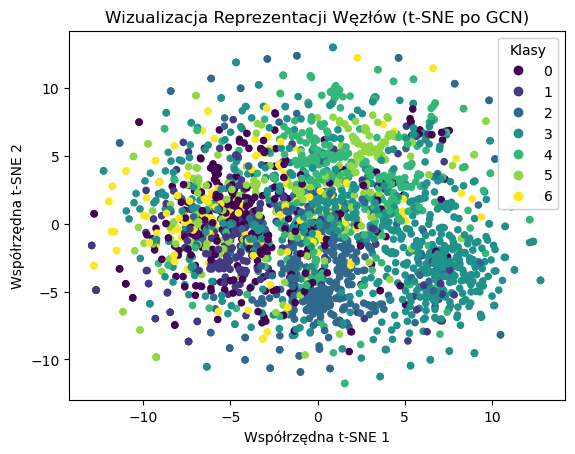

In [9]:

scatter = plt.scatter(
    original_features_2d[:, 0], # Współrzędna X
    original_features_2d[:, 1], # Współrzędna Y
    c=true_labels,       # Kolorowanie według prawdziwej etykiety
    cmap='viridis',
    s=20
)

legend1 = plt.legend(*scatter.legend_elements(), 
                     title="Klasy", 
                     loc="upper right")
plt.gca().add_artist(legend1)
plt.title("Wizualizacja Reprezentacji Węzłów (t-SNE po GCN)")
plt.xlabel("Współrzędna t-SNE 1")
plt.ylabel("Współrzędna t-SNE 2")
plt.show()